In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6234296062190840323, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9202108990
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4132287614919092521
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import os
import numpy as np

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import Conv2D, Dropout ,MaxPool2D, AvgPool2D
from keras.layers import Input, Flatten, Dense, Activation
from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
train_dir = 'data/combined/train'
validation_dir = 'data/combined/validation'
test_dir = 'data/combined/test'

In [5]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))
    
print("*"*30)

for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))
    
print("*"*30)

for root,dirs,files in os.walk(test_dir):
    print (root, len(files))   

data/combined/train 0
data/combined/train\benign 1485
data/combined/train\malignant 2762
******************************
data/combined/validation 0
data/combined/validation\benign 183
data/combined/validation\malignant 368
******************************
data/combined/test 0
data/combined/test\benign 189
data/combined/test\malignant 414


In [6]:
output_classes = 2
batch_size = 32 
img_height, img_width = 256, 256

nb_train_samples = 4247
nb_validation_samples = 551
nb_test_samples = 603

In [7]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [8]:
random_seed = np.random.seed(1180)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 4247 images belonging to 2 classes.
Found 551 images belonging to 2 classes.
Found 603 images belonging to 2 classes.


In [9]:
epochs = 50

droput_rate= 0.6
rmsprop=RMSprop(lr=0.0001, rho=0.3, epsilon=None, decay=0.0004)

In [10]:
def inception_block(X, filters, stage, initializer='he_normal'):
    """
    Origin version inception block
    Args:
        X -- Input tensor, shape: (batch_size, W, H, C)
        filters -- List of number filters, corresponding to
            1x1, 3x3_reduce, 3x3, 5x5_reduce, 5x5, pool_proj convolutions
        stage -- Integer, used to name the stages
        initializer -- Kernel initializer
    Return:
        Output tensor
    """
    f1, f3_r, f3, f5_r, f5, fp = filters
    basename = 'stage' + str(stage) + '_'
    
    X_1 = Conv2D(f1, kernel_size=1, padding='SAME', activation='relu',
                 kernel_initializer=initializer, name=basename+'1_1')(X)
    X_3_reduce = Conv2D(f3_r, kernel_size=1, padding='SAME', activation='relu',
                        kernel_initializer=initializer, name=basename+'3_3_reduce')(X)
    X_3 = Conv2D(f3, kernel_size=3, padding='SAME', activation='relu',
                 kernel_initializer=initializer, name=basename+'3_3')(X)
    X_5_reduce = Conv2D(f5_r, kernel_size=1, padding='SAME', activation='relu',
                        kernel_initializer=initializer, name=basename+'5_5_reduce')(X)
    X_5 = Conv2D(f5, kernel_size=5, padding='SAME', activation='relu',
                 kernel_initializer=initializer, name=basename+'5_5')(X)
    X_pooling = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='SAME',
                          name=basename+'incep_pool')(X)
    X_p = Conv2D(fp, kernel_size=1, padding='SAME', activation='relu',
                 kernel_initializer=initializer, name=basename+'pool_1_1')(X)
    
    output = keras.layers.concatenate([X_1, X_3, X_5, X_p], axis=-1)
    return output

def inception_v1(input_shape, n_classes, initializer='he_normal'):
    X_input = keras.Input(shape=input_shape)
    
    # Stage 1
    X = Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu',
               kernel_initializer=initializer, name='stage1_conv1')(X_input)
    X = Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu',
               kernel_initializer=initializer, name='stage1_conv2')(X)
    X = MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='stage1_maxpool')(X)
    # Stage 2
    X = inception_block(X, [64, 96, 128, 16, 32, 32], stage=2, initializer=initializer)
    X = MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='stage2_maxpool')(X)
    # Stage 3
    X = inception_block(X, [128, 128, 192, 32, 96, 64], stage=3, initializer=initializer)
    X = MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='stage3_maxpool')(X)
    # Stage 4
    X = AvgPool2D(pool_size=(4, 4))(X)
    X = Flatten()(X)
    X = Dropout(droput_rate)(X)
    X = Dense(n_classes, activation='softmax',
              kernel_initializer=initializer, name='stage4_dense1')(X)
    
    model = keras.Model(inputs=X_input, outputs=X)
    
    model.compile(loss='categorical_crossentropy',
              optimizer= rmsprop,
              metrics = ["accuracy"])
    
    return model

In [11]:
model = inception_v1((256, 256, 3), 2)

In [12]:
# history = model.fit_generator(train_generator,
#     steps_per_epoch=nb_train_samples // batch_size,
#     epochs = 50,
#     validation_data = validation_generator,
#     validation_steps=nb_validation_samples // batch_size,
#     callbacks=[lr_scheduler, csv_logger, checkpointer, tensorboard, early_stopping])

history = model.fit_generator(train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
132/132 [==============================] - 27s 208ms/step - loss: 0.6338 - acc: 0.6551 - val_loss: 0.5140 - val_acc: 0.7518
Epoch 2/50
132/132 [==============================] - 25s 192ms/step - loss: 0.5428 - acc: 0.7559 - val_loss: 0.4995 - val_acc: 0.7611
Epoch 3/50
132/132 [==============================] - 24s 182ms/step - loss: 0.5191 - acc: 0.7790 - val_loss: 0.5319 - val_acc: 0.7572
Epoch 4/50
132/132 [==============================] - 24s 182ms/step - loss: 0.5113 - acc: 0.7884 - val_loss: 0.5816 - val_acc: 0.6936
Epoch 5/50
132/132 [==============================] - 24s 183ms/step - loss: 0.5071 - acc: 0.7946 - val_loss: 0.4715 - val_acc: 0.7996
Epoch 6/50
132/132 [==============================] - 24s 183ms/step - loss: 0.4997 - acc: 0.7981 - val_loss: 0.4850 - val_acc: 0.8150 0.4988 - - ETA: 2s - loss: 0.5
Epoch 7/50
132/132 [==============================] - 24s 183ms/step - loss: 0.4884 - acc: 0.8081 - val_loss: 0.4755 - val_acc: 0.8208
Epoch 8/50
132/132 [====

In [13]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.44806549343906465
Validation Accuracy:  0.8045901641689364


In [47]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

19/18 [==============================] - 1s 73ms/step
No of errors = 114/603


Confusion Matrix
[[ 91  98]
 [ 16 398]]


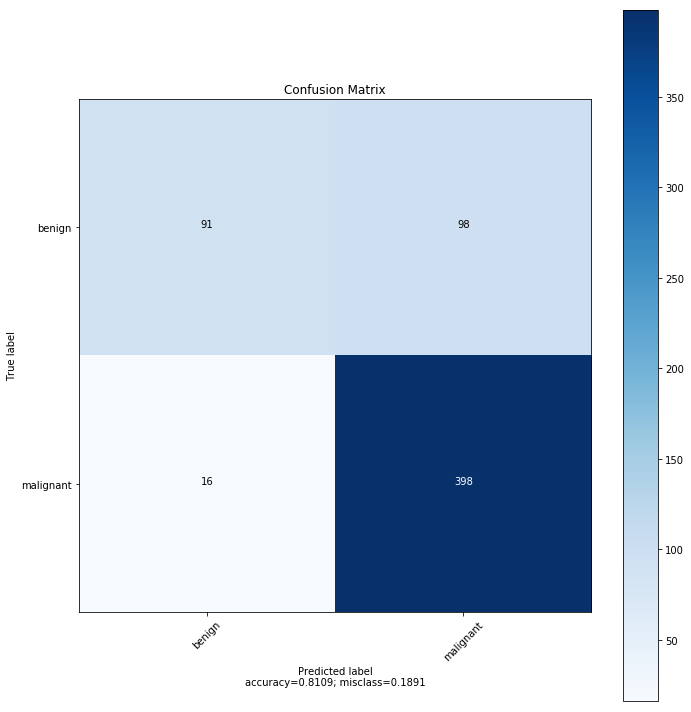

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/1.Xception-CM.png', bbox_inches='tight', dpi = 100) 

plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

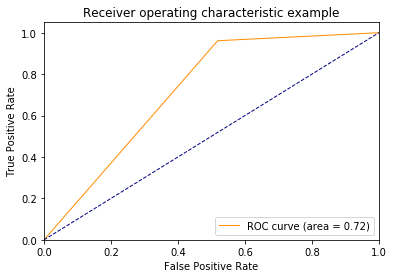

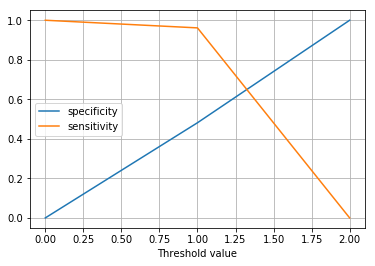

In [55]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [56]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
%matplotlib inline

dict_characters = {0: 'Benign', 1: 'Malignant'}

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [57]:
from sklearn.metrics import roc_auc_score
predicts = [x[0] for x in predicts]
roc_auc_score(test_generator.classes, predicts)

IndexError: invalid index to scalar variable.

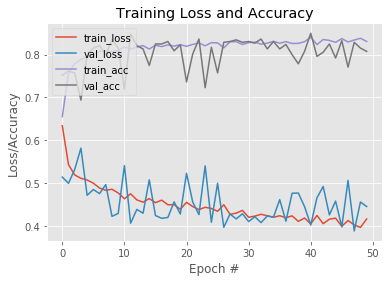

In [58]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

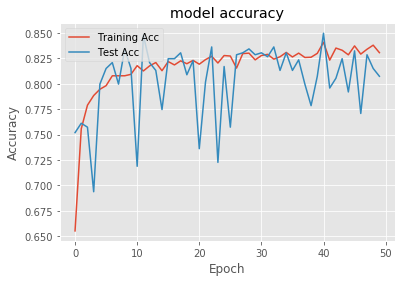

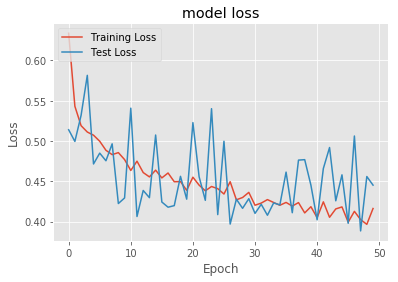

In [59]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

In [60]:
model.save('models/2.InceptionV1-Combined-Dataset-Model.h5')
model.save_weights('models/2.InceptionV1-Combined-Dataset-Weights.h5')